In [1]:
 #===================================================== Import libraries ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# ================================================= Flexible Layer ================================================================================

    
class FlexiLayer(nn.Module): # class FlexiLayer(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        super(FlexiLayer, self).__init__()
        
        self.t_1 = nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.padding)
        self.t_2 = nn.MaxPool2d(self.kernel_size, self.stride, self.padding) # get max result with the same kernel size
        self.m = nn.Sigmoid()
        
        self.threshold1 = Variable(torch.randn((1, self.out_channels, 30, 30)))
        
        self.thresh_mean = []
        
    def forward(self, t):
        
        self.threshold1.expand(t.size(0), self.out_channels, 30, 30)
        
        
        cond = torch.sub(self.t_2(t), self.threshold1.cuda())
        t_2_2 = self.m(cond*50)*self.t_2(t) # 
        t_1_1 = self.m(cond*(-50))*self.t_1(t) # 
        t = torch.add(t_2_2, t_1_1)
        
        return t

    # ================================================= VGG-16 Network ================================================================================
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16,self).__init__()

        self.block1 = nn.Sequential(
                      nn.Conv2d(in_channels = 3,out_channels = 64,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      FlexiLayer(in_channels = 64,out_channels = 64,kernel_size = 3, padding =0),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      #nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.3))

        self.block2 = nn.Sequential(
                      nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 128,out_channels = 128,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.4))

        self.block3 = nn.Sequential(
                      nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.4))

        self.block4 = nn.Sequential(
                      nn.Conv2d(in_channels = 256,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2) ,
                      nn.Dropout2d(0.4))

        self.block5 = nn.Sequential(
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.5) )

        self.fc =     nn.Sequential(
                      nn.Linear(512,100),
                      nn.Dropout(0.5),
                      nn.BatchNorm1d(100),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(100,10), )




    def forward(self,x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = out.view(out.size(0),-1)
        out = self.fc(out)

        return out


In [2]:
 #===================================================== Import libraries ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

#from models.VGG16_with_flex_v5 import *


# =================================================== Prepare the dataset ===============================================================================

mean_cifar10 = [0.485, 0.456, 0.406]  # Mean and Std value hase been taken from a github implmentation online.
std_cifar10 = [0.229, 0.224, 0.225]
batch_size = 100
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])


trainset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=True, download= True, transform=transform_train)

#create a dataset subset
sampler_train = list(range(0, len(trainset), 50))
trainset_samp = torch.utils.data.Subset(trainset, sampler_train)

trainloader = torch.utils.data.DataLoader(trainset_samp, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # 10 Classes of the cifar-10

# ========================================== Visualising the dataset ==========================================================================
std= torch.FloatTensor(std_cifar10)
mean = torch.FloatTensor(mean_cifar10)
mean = mean[:,None,None]
std = std[:,None,None]
def imshow(img):
    print(img.size())
    img = img*std + mean     # unnormalize
    
    npimg = img.numpy()
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 36, 138])
 frog  bird  bird  deer


In [3]:
# =============================================================== Model initialisation, Loss function and Optimizer =====================================
model = VGG16()
if torch.cuda.is_available():
    model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)
schedule = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma = 0.7)

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

14,775,646 total parameters.
14,775,646 trainable parameters.


Epoch:  0   Loss:  24.266616106033325   Train Accuracy : 11.6


Test accuracy: 10 %
Epoch:  1   Loss:  24.035996913909912   Train Accuracy : 8.9


Test accuracy: 10 %
Epoch:  2   Loss:  23.693939685821533   Train Accuracy : 11.9


Test accuracy: 10 %
Epoch:  3   Loss:  23.673046827316284   Train Accuracy : 13.4


Test accuracy: 9 %
Epoch:  4   Loss:  23.493891716003418   Train Accuracy : 12.8


Test accuracy: 10 %
Epoch:  5   Loss:  23.037204265594482   Train Accuracy : 12.0


Test accuracy: 10 %
Epoch:  6   Loss:  23.112723350524902   Train Accuracy : 12.9


Test accuracy: 10 %
Epoch:  7   Loss:  22.781374216079712   Train Accuracy : 13.8


Test accuracy: 10 %
Epoch:  8   Loss:  22.884896278381348   Train Accuracy : 14.6


Test accuracy: 10 %
Epoch:  9   Loss:  22.899085521697998   Train Accuracy : 15.4


Test accuracy: 10 %
Epoch:  10   Loss:  22.78309917449951   Train Accuracy : 14.9


Test accuracy: 10 %
Epoch:  11   Loss:  22.603595733642578   Train Accuracy : 15.0


Test accuracy

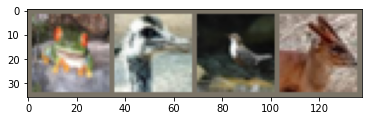

In [4]:
# ======================== Function to get the test accuracy ===============================================================================
def test():
    correct = 0
    total = 0
    model.train(False)
    with torch.no_grad():
        for i,(images,labels)in enumerate(testloader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(Variable(images))
            labels = Variable(labels)
            _,predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted.eq(labels)).sum().item()
        print('Test accuracy: %d %%' % (
            100 * correct / total))
    return 100*(correct/total)

#======================================================= Training =========================================================================
num_epochs = 152  # Train for 150 epochs
start_epoch = 0

total_step = len(trainloader)
train_loss = []  # Store the train_loss per epoch
test_accuracy = [] # Store the test_accuracy per epoch
for epoch in range(start_epoch,num_epochs+1):
    model.train(True)
    epoch_loss  = 0
    i_count = 0
    acc_total = 0
    for i,(images,labels) in enumerate(trainloader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        labels = Variable(labels)
        optimizer.zero_grad()
        outputs = model(Variable(images))
        loss = criterion(outputs,labels)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        _,predicted = outputs.max(1)
        denom = labels.size(0)
        correct = predicted.eq(labels).sum().item()
        acc = 100*(correct/denom)
        acc_total += acc
        i_count = i_count + 1
    
    #if(i%20 == 0):  # Print the loss per 20 iterations
      #print("Epoch: ",epoch," ","Iteration: ",i," loss: ",loss.item()," Train_iter Accuracy: ",acc)
    schedule.step()
    train_loss.append(epoch_loss)
    print("Epoch: ",epoch," ","Loss: ",epoch_loss," ","Train Accuracy :",acc_total/i_count) # Print train accuracy per epoch
    print('\n')
    test_acc = test()      # Print the test accuracy per epoch
    test_accuracy.append(test_acc)
  
    state = {
        'model': model.state_dict(),
        'acc' : test_acc,
        'optim':optimizer.state_dict(),
        'epoch' : epoch
    }
    path = './models/VGG16-flex-v5-block1-nnmodule_50xdownsampled' + 'model_' + str(int(epoch)) +'_' + str(int(test_acc))+'.pth'
    torch.save(state,path)


In [5]:
test_accuracy

[10.0,
 10.0,
 10.0,
 9.969999999999999,
 10.35,
 10.4,
 10.41,
 10.299999999999999,
 10.45,
 10.38,
 10.38,
 10.45,
 10.51,
 10.23,
 10.54,
 10.57,
 10.89,
 11.200000000000001,
 11.469999999999999,
 11.92,
 12.42,
 12.32,
 13.370000000000001,
 13.28,
 13.750000000000002,
 14.330000000000002,
 14.95,
 14.99,
 15.459999999999999,
 15.49,
 15.879999999999999,
 16.23,
 16.580000000000002,
 18.3,
 18.78,
 18.8,
 19.25,
 18.78,
 18.310000000000002,
 18.22,
 18.69,
 19.25,
 20.26,
 20.77,
 20.57,
 20.71,
 20.45,
 20.52,
 19.66,
 19.6,
 20.39,
 20.48,
 19.89,
 19.900000000000002,
 19.900000000000002,
 19.49,
 19.37,
 20.13,
 20.669999999999998,
 20.95,
 21.3,
 21.94,
 21.61,
 21.54,
 22.29,
 22.25,
 22.27,
 21.91,
 21.85,
 22.03,
 21.97,
 22.29,
 22.220000000000002,
 21.9,
 22.74,
 23.09,
 23.150000000000002,
 22.95,
 22.96,
 23.189999999999998,
 23.21,
 23.41,
 23.28,
 23.71,
 23.45,
 23.54,
 23.51,
 23.52,
 24.11,
 23.46,
 23.669999999999998,
 23.73,
 23.580000000000002,
 23.630000000000003

In [6]:
import pickle

with open("flex_downsampled_accuracy.pkl", "wb") as output_file:
        pickle.dump(test_accuracy, output_file)

In [7]:
# #======================================= Testing ===================================================================================================
# test_acc = test() # Test error
# print(test_acc)

# # Per class accuracy
# class_correct = list(0. for i in range(10)) # Individual class error
# class_total = list(0. for i in range(10))
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         if torch.cuda.is_available():
#           images = images.cuda()
#           labels = labels.cuda()
#         images = Variable(images)
#         labels = Variable(labels)
#         outputs = model(images)
#         _, predicted = torch.max(outputs, 1)
#         c = (predicted == labels).squeeze()
#         for i in range(4):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1

# for i in range(10):
#     print('Accuracy of %5s : %2d %%' % (
#         classes[i], 100 * class_correct[i] / class_total[i]))

In [8]:
# '''  
# The image lies between [0,1] but since I have trained the whole network on normalized input, Therefore
# the min_val = -2.117 and max_val = 2.64 and not {0,1}
# '''

# # FGSM attack code
# def fgsm_attack(image, epsilon, data_grad):
#     # Collect the element-wise sign of the data gradient
#     sign_data_grad = data_grad.sign()
#     # Create the perturbed image by adjusting each pixel of the input image
#     perturbed_image = image + epsilon*sign_data_grad
#     # Adding clipping to maintain [0,1] range
#     perturbed_image = torch.clamp(perturbed_image, -2.117, 2.64)
#     # Return the perturbed image
#     return perturbed_image

# def test( model, device, test_loader, epsilon ):

#     # Accuracy counter
#     correct = 0
#     adv_examples = []

#     # Loop over all examples in test set
#     for data, target in test_loader:

#         # Send the data and label to the device
#         data, target = data.to(device), target.to(device)

#         # Set requires_grad attribute of tensor. Important for Attack
#         data.requires_grad = True

#         # Forward pass the data through the model
#         output = model(data)
#         init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

#         # If the initial prediction is wrong, dont bother attacking, just move on
#         #if init_pred.item() != target.item():
#         #    continue

#         # Calculate the loss
#         loss = F.nll_loss(output, target)

#         # Zero all existing gradients
#         model.zero_grad()

#         # Calculate gradients of model in backward pass
#         loss.backward()

#         # Collect datagrad
#         data_grad = data.grad.data

#         # Call FGSM Attack
#         perturbed_data = fgsm_attack(data, epsilon, data_grad)

#         # Re-classify the perturbed image
#         output = model(perturbed_data)

#         # Check for success
#         final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
#         for i in range(0,len(final_pred)-1):
#             if final_pred[i].sub(target[i]) == 0:
#                 correct += 1
#                 # Special case for saving 0 epsilon examples
#                 if (epsilon == 0) and (len(adv_examples) < 5):
#                     adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
#                     adv_examples.append( (init_pred[i], final_pred[i], adv_ex) )
#             else:
#                 # Save some adv examples for visualization later
#                 if len(adv_examples) < 5:
#                     adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
#                     adv_examples.append( (init_pred[i], final_pred[i], adv_ex) )

#     # Calculate final accuracy for this epsilon
#     final_acc = correct/float(len(test_loader))
#     print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

#     # Return the accuracy and an adversarial example
#     return final_acc, adv_examples

In [9]:
# #evaluate model
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         outputs = model(images.cuda())
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels.cuda()).sum().item()

# print('Accuracy on the test dataset is: %f %%' % (
#     100 * correct / total))

In [10]:
# accuracies = []
# examples = []
# epsilons = [0, .05, .1, .15, .2, .25, .3]

# # Define what device we are using
# print("CUDA Available: ",torch.cuda.is_available())
# use_cuda=True
# device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# # Run test for each epsilon
# for eps in epsilons:
#     acc, ex = test(model, device, testloader, eps)
#     accuracies.append(acc)
#     examples.append(ex)

In [11]:
# plt.figure(figsize=(5,5))
# plt.plot(epsilons, torch.tensor(accuracies).div(100), "*-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
# plt.title("Accuracy vs Epsilon")
# plt.xlabel("Epsilon")
# plt.ylabel("Accuracy")
# plt.show()

In [12]:
# import matplotlib.pyplot as plt
# import numpy as np

# epsilons = [0, .05, .1, .15, .2, .25, .3]
# accuracies = np.divide(accuracies, 100)
# accuracies1 = [0.8881, 0.2799, 0.1636, 0.1375, 0.1325, 0.1327, 0.1359]
# accuraciesA = [86.03,
# 45.05,
# 31.15,
# 26.59,
# 24.5,
# 23.01,
# 21.35,
# ]
# accuraciesB = [79.62,
# 36.57,
# 21.01,
# 15.78,
# 13.75,
# 12.67,
# 12.38,
# ]
# accuraciesC = [84.57,
# 36.22,
# 25.87,
# 22.22,
# 20.14,
# 19.32,
# 19.39,
# ]
# accuraciesD = [86.99,
# 41.49,
# 31.85,
# 28.82,
# 27.48,
# 25.98,
# 24.86,
# ]
# accuraciesA = np.divide(accuraciesA, 100)
# accuraciesB = np.divide(accuraciesB, 100)
# accuraciesC = np.divide(accuraciesC, 100)
# accuraciesD = np.divide(accuraciesD, 100)
# plt.figure(figsize=(5,5))
# plt.plot(epsilons, accuracies1, "*-", label = "Baseline VGG16")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.plot(epsilons, accuracies, "*-", label = "FlexiVGG16(2)")
# plt.xticks(np.arange(0, .35, step=0.05))
# plt.plot(epsilons, accuraciesA, "*-", label = "A")
# plt.xticks(np.arange(0, .35, step=0.05))
# plt.plot(epsilons, accuraciesB, "*-", label = "B")
# plt.xticks(np.arange(0, .35, step=0.05))
# plt.plot(epsilons, accuraciesC, "*-", label = "C")
# plt.xticks(np.arange(0, .35, step=0.05))
# plt.plot(epsilons, accuraciesD, "*-", label = "D")
# plt.xticks(np.arange(0, .35, step=0.05))
# #plt.plot(epsilons, accuracies3, "*-", label = "FlexiVGG16_batch_indep_100epochs")
# plt.title("FGSM Testing Accuracy vs Epsilon")
# plt.xlabel("Epsilon")
# plt.ylabel("Testing Accuracy")
# plt.legend()
# #plt.savefig('./figures/fgsm_testing_results.png', format='png')
# plt.show()